In [33]:
import pandas as pd
import numpy as np
import math 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score,\
precision_recall_curve, f1_score, fbeta_score, accuracy_score, log_loss
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('Fraud.csv')
df = data.copy()

### Data Cleaning & Processing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
na = df.isna().sum()
na

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
df['step'] = df['step'].apply(lambda x: x/24)

In [6]:
df['step'] = df['step'].apply(lambda x: math.ceil(x))

In [7]:
df = pd.get_dummies(df, columns=['type'])

In [8]:
df = df.drop(columns=['isFlaggedFraud'])

In [9]:
df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,1,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,31,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,1,0,0,0
6362616,31,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0,0,0,1
6362617,31,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,1,0,0,0
6362618,31,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0,0,0,1


In [10]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [11]:
#remove all the nameDest rows that lead with 'M' because based on the data set, there is no 
#information for merchant transactions
name_remov = df['nameDest'].str.contains('M')
df_clean = df[~name_remov]

In [12]:
#No merchants in nameOrig
merch_out = df_clean['nameOrig'].str.contains('M')
merch_out.unique()

array([False])

In [13]:
#move the isFraud column to new index
col = df_clean.pop("isFraud")
df_clean.insert(0, col.name, col)

In [14]:
df_clean

,isFraud,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2,1,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,0,0,0,1
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1,0,0,0
9,0,1,5337.77,C712410124,41720.00,36382.23,C195600860,41898.00,40348.79,0,0,1,0,0
10,0,1,9644.94,C1900366749,4465.00,0.00,C997608398,10845.00,157982.12,0,0,1,0,0
15,0,1,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,1,31,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,0,1,0,0,0
6362616,1,31,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,0,0,0,0,1
6362617,1,31,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,0,1,0,0,0
6362618,1,31,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,0,0,0,0,1


### Attempt 1: Remove Customer ID
#### Logistic Regression

In [216]:
#new data frame to start playing around with different features
df_no_name = df_clean.copy()

In [217]:
#drop object columns & convert all to float
df_no_name = df_no_name.drop(columns=['nameOrig','nameDest'])
df_no_name = df_no_name.astype('float64')

In [218]:
X_train, X_test, y_train, y_test = train_test_split(df_no_name.iloc[:,1:], df_no_name.iloc[:,0], random_state=66)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [219]:
#High score but probably because a very small amount of the transactions
#are actually fraud
log_reg.score(X_train,y_train)

0.9980888712847211

In [221]:
#run confusion matrix, derived code from lesson
def make_confusion_matrix(model, threshold=0.05):
    predict = (model.predict_proba(X_test)[:,1] >= threshold)
    fraud = confusion_matrix(y_test, predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud, cmap=plt.cm.Reds, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    print("Threshold of: {}".format(threshold))
    print("Precision: {:1.3f}, Recall: {:1.3f}".format(precision_score(y_test, predict), recall_score(y_test, predict)))

Threshold of: 0.05
Precision: 0.053, Recall: 0.629


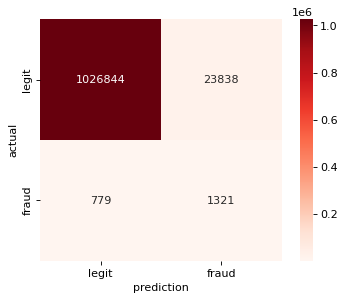

In [222]:
#sacrifice precision for recall
make_confusion_matrix(log_reg)

In [134]:
#F1 score with standard 0.5 threshold
y_predict = log_reg.predict(X_test)
f1_score(y_test, y_predict)

0.4633184328161977

In [135]:
fbeta_score(y_test, y_predict, beta = 2)

0.43600910620607736

In [136]:
#F1 score with threshold that gives highest score
y_predict = (log_reg.predict_proba(X_test)[:, 1] > 0.8)
f1_score(y_test, y_predict)

0.5170797052913596

In [137]:
#applies 2 times more importance to recall than precision
#but the score drops
fbeta_score(y_test, y_predict, beta = 2)

0.41567951755330607

ROC AUC score =  0.9487836598831363


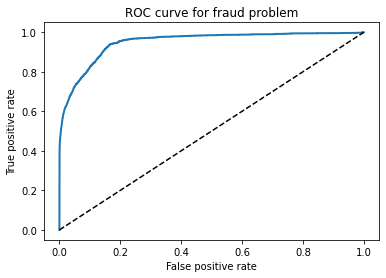

In [138]:
false_p, true_p, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])

plt.plot(false_p, true_p,lw=2)
plt.plot([0,1],[0,1],c='black',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]))

### Attempt 2: Transaction Difference
Feature engineering + over sampling

In [15]:
df_difference = df_clean.copy()

In [16]:
#calculate the leftover balance after the transaction amount
#both for the sender(original) and receiver(destination)
acct_leftover_orig = df_difference['newbalanceOrig'] - df_difference['oldbalanceOrg']

df_difference.insert(6, 'acct_leftover_orig', acct_leftover_orig)
acct_leftover_dest = df_difference['newbalanceDest'] - df_difference['oldbalanceDest']
df_difference.insert(10, 'acct_leftover_dest', acct_leftover_dest)

In [17]:
#find the rows where the transaction amount equals the full sender 
#account balance - figure people don't usually use up all their money
#in the account at once
df_difference.loc[df_difference['amount'] == df_difference['oldbalanceOrg']]

,isFraud,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,acct_leftover_orig,nameDest,oldbalanceDest,newbalanceDest,acct_leftover_dest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2,1,1,181.00,C1305486145,181.00,0.0,-181.00,C553264065,0.00,0.00,0.00,0,0,0,0,1
3,1,1,181.00,C840083671,181.00,0.0,-181.00,C38997010,21182.00,0.00,-21182.00,0,1,0,0,0
251,1,1,2806.00,C1420196421,2806.00,0.0,-2806.00,C972765878,0.00,0.00,0.00,0,0,0,0,1
252,1,1,2806.00,C2101527076,2806.00,0.0,-2806.00,C1007251739,26202.00,0.00,-26202.00,0,1,0,0,0
680,1,1,20128.00,C137533655,20128.00,0.0,-20128.00,C1848415041,0.00,0.00,0.00,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,1,31,339682.13,C786484425,339682.13,0.0,-339682.13,C776919290,0.00,339682.13,339682.13,0,1,0,0,0
6362616,1,31,6311409.28,C1529008245,6311409.28,0.0,-6311409.28,C1881841831,0.00,0.00,0.00,0,0,0,0,1
6362617,1,31,6311409.28,C1162922333,6311409.28,0.0,-6311409.28,C1365125890,68488.84,6379898.11,6311409.27,0,1,0,0,0
6362618,1,31,850002.52,C1685995037,850002.52,0.0,-850002.52,C2080388513,0.00,0.00,0.00,0,0,0,0,1


In [18]:
#drop columns to reduce noise
df_difference = df_difference.drop(columns=['step','nameOrig','nameDest','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [19]:
df_difference

,isFraud,amount,acct_leftover_orig,acct_leftover_dest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2,1,181.00,-181.00,0.00,0,0,0,0,1
3,1,181.00,-181.00,-21182.00,0,1,0,0,0
9,0,5337.77,-5337.77,-1549.21,0,0,1,0,0
10,0,9644.94,-4465.00,147137.12,0,0,1,0,0
15,0,229133.94,-15325.00,46430.44,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
6362615,1,339682.13,-339682.13,339682.13,0,1,0,0,0
6362616,1,6311409.28,-6311409.28,0.00,0,0,0,0,1
6362617,1,6311409.28,-6311409.28,6311409.27,0,1,0,0,0
6362618,1,850002.52,-850002.52,0.00,0,0,0,0,1


In [20]:
#create train test split with random sampling using the amount column as the row identifier
#create train test split using isFraud as the feature
np.random.seed(33)
total_amount = df_difference['amount']
test_amount = np.random.choice(total_amount, size=int(total_amount.shape[0] * .30))

df_X_tr, df_X_te = df_difference[~df_difference['amount'].isin(test_amount)], df_difference[df_difference['amount'].isin(test_amount)]

y_tr, y_te = df_X_tr['isFraud'], df_X_te['isFraud']
X_tr, X_te = df_X_tr.drop(['isFraud'],axis=1), \
             df_X_te.drop(['isFraud'],axis=1)

In [23]:
# setup for the ratio of over sampling
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=88) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_tr, y_tr)

log_reg = LogisticRegression(solver='liblinear') 
log_reg.fit(X_tr, y_tr)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, log_reg.predict(X_te)), roc_auc_score(y_te, log_reg.predict_proba(X_te)[:,1]))) 

logreg_os = LogisticRegression(solver='liblinear') 
logreg_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, logreg_os.predict(X_te)), roc_auc_score(y_te, logreg_os.predict_proba(X_te)[:,1])))

print('fbeta score on Oversampled Train Data; Test Fbeta: %.3f, Test AUC: %.3f' % \
      (fbeta_score(y_te, logreg_os.predict(X_te), beta=4), roc_auc_score(y_te, logreg_os.predict_proba(X_te)[:,1])))

Simple Logistic Regression; Test F1: 0.485, Test AUC: 0.987
Logistic Regression on Oversampled Train Data; Test F1: 0.438, Test AUC: 0.955
fbeta score on Oversampled Train Data; Test F1: 0.491, Test AUC: 0.955


### Attempt 3: Dropped Dummy Variables

Feature engineering + over sampling + class weight balance

In [24]:
df_userID = df_clean.copy()

In [25]:
df_userID = df_userID.drop(columns=['step','type_CASH_IN','type_DEBIT','type_PAYMENT'])

In [26]:
df_userID['nameOrig'] = df_userID['nameOrig'].str.replace('C','')
df_userID['nameDest'] = df_userID['nameDest'].str.replace('C','')

In [167]:
#run over sampling with new set of features
#aim to categorize by userID by random sampling
np.random.seed(6)
total_users = df_userID['nameOrig'].unique() 
test_users = np.random.choice(total_users, size=int(total_users.shape[0] * .30))

df_X_tr, df_X_te = df_userID[~df_userID['nameOrig'].isin(test_users)], df_userID[df_userID['nameOrig'].isin(test_users)]

y_tr, y_te = df_X_tr['isFraud'], df_X_te['isFraud']
X_tr, X_te = df_X_tr.drop(['isFraud'],axis=1), \
             df_X_te.drop(['isFraud'],axis=1)


In [168]:
# setup for the ratio of over sampling
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=20) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_tr, y_tr)

log_reg = LogisticRegression(solver='liblinear') 
log_reg.fit(X_tr, y_tr)

print('Simple Logistic Regression; Test F1: %.3f, Recall: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, log_reg.predict(X_te)), recall_score(y_te, log_reg.predict(X_te)),roc_auc_score(y_te, log_reg.predict_proba(X_te)[:,1]))) 

logreg_os = LogisticRegression(solver='liblinear') 
logreg_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Recall: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, logreg_os.predict(X_te)), recall_score(y_te, logreg_os.predict(X_te)),roc_auc_score(y_te, logreg_os.predict_proba(X_te)[:,1])))

print('Logistic Regression on Oversampled Train Data; Test Fbeta: %.3f' % \
      (fbeta_score(y_te, logreg_os.predict(X_te), beta = 4)))

Simple Logistic Regression; Test F1: 0.559, Recall: 0.440, Test AUC: 0.953
Logistic Regression on Oversampled Train Data; Test F1: 0.536, Recall: 0.518, Test AUC: 0.960
Logistic Regression on Oversampled Train Data; Test Fbeta: 0.520


In [203]:
#try with manipulating class weights
logrg_balanced = LogisticRegression(class_weight='balanced', solver='liblinear')
logrg_4x = LogisticRegression(class_weight={1 : 50, 0 : 1}, solver='liblinear')

logrg_balanced.fit(X_tr, y_tr)
print('Balanced class weights Logistic Regression Test F1: %.3f, Recall: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, logrg_balanced.predict(X_te)), recall_score(y_te, logrg_balanced.predict(X_te)), roc_auc_score(y_te, logrg_balanced.predict_proba(X_te)[:,1])))

logrg_4x.fit(X_tr, y_tr)
print('4:1 class weights Logistic Regression Test F1: %.3f, Recall: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, logrg_4x.predict(X_te)),recall_score(y_te, logrg_4x.predict(X_te)), roc_auc_score(y_te, logrg_4x.predict_proba(X_te)[:,1])))

#decided to not use fbeta as that score drops as I increase the emphasis on recall
print('4:1 class weights fbeta Test Fbeta: %.3f' % \
      (fbeta_score(y_te, logrg_4x.predict(X_te), beta = 4)))

Balanced class weights Logistic Regression Test F1: 0.055, Recall: 0.903, Test AUC: 0.978
4:1 class weights Logistic Regression Test F1: 0.240, Recall: 0.718, Test AUC: 0.977
4:1 class weights fbeta Test Fbeta: 0.582


In [204]:
#how confident is each model?
#Lower the log-loss score, the better the predictions
print("Log-loss score logistic regression: {:6.4f}".format(log_loss(y_te, log_reg.predict_proba(X_te))))
print("Log-loss score over sampling: {:6.4f}".format(log_loss(y_te, logreg_os.predict_proba(X_te))))
print("Log-loss score class weight balance: {:6.4f}".format(log_loss(y_te, logrg_4x.predict_proba(X_te))))

Log-loss score logistic regression: 0.0090
Log-loss score over sampling: 0.0123
Log-loss score class weight balance: 0.0477


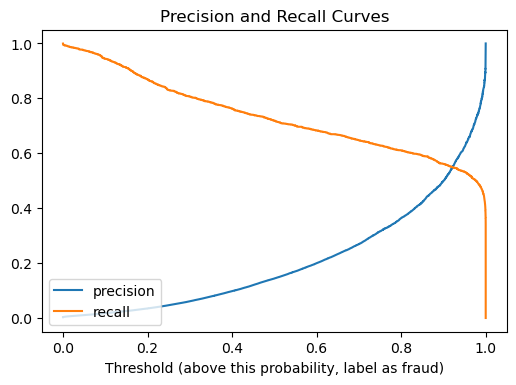

In [213]:
#use 4:1 class weight regression as that has the best recall score and decent F1 score

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, logrg_4x.predict_proba(X_te)[:,1] )

plt.figure(dpi=100)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [227]:
def fraud_confusion_matrix(model, threshold=0.5):
    predict = (model.predict_proba(X_te)[:,1] >= threshold)
    fraud = confusion_matrix(y_te, predict)
    plt.figure(dpi=100)
    sns.heatmap(fraud, cmap=plt.cm.Reds, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    print("Threshold of: {}".format(threshold))
    print("Precision: {:1.3f}, Recall: {:1.3f}".format(precision_score(y_te, predict), recall_score(y_te, predict)))

Threshold of: 0.5
Precision: 0.144, Recall: 0.718


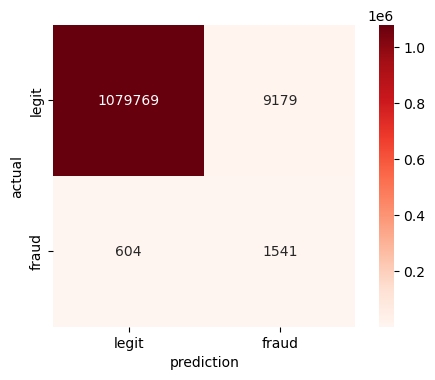

In [228]:
fraud_confusion_matrix(logrg_4x)

### Attempt 4: Dropped Transaction Destination 

feature engineering + oversampling + class weight balance

In [115]:
df_sender = df_clean.copy()

In [116]:
df_sender = df_sender.drop(columns=['step','nameDest','oldbalanceDest','newbalanceDest'])

In [117]:
df_sender['nameOrig'] = df_sender['nameOrig'].str.replace('C','')

In [118]:
total_users = df_sender['nameOrig'].unique() 
test_users = np.random.choice(total_users, size=int(total_users.shape[0] * .30))

df_X_tr, df_X_te = df_sender[~df_sender['nameOrig'].isin(test_users)], df_sender[df_sender['nameOrig'].isin(test_users)]

y_tr, y_te = df_X_tr['isFraud'], df_X_te['isFraud']
X_tr, X_te = df_X_tr.drop(['isFraud'],axis=1), \
             df_X_te.drop(['isFraud'],axis=1)

In [119]:
# setup for the ratio of over sampling
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_tr, y_tr)

log_reg = LogisticRegression(solver='liblinear') 
log_reg.fit(X_tr, y_tr)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, log_reg.predict(X_te)), roc_auc_score(y_te, log_reg.predict_proba(X_te)[:,1]))) 

logreg_os = LogisticRegression(solver='liblinear') 
logreg_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, logreg_os.predict(X_te)), roc_auc_score(y_te, logreg_os.predict_proba(X_te)[:,1])))

Simple Logistic Regression; Test F1: 0.360, Test AUC: 0.923
Logistic Regression on Oversampled Train Data; Test F1: 0.309, Test AUC: 0.935


In [120]:
#try with manipulating class weights
logrg_balanced = LogisticRegression(class_weight='balanced', solver='liblinear')
logrg_4x = LogisticRegression(class_weight={1 : 4, 0 : 1}, solver='liblinear')

logrg_balanced.fit(X_tr, y_tr)
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, logrg_balanced.predict(X_te)), roc_auc_score(y_te, logrg_balanced.predict_proba(X_te)[:,1])))

logrg_4x.fit(X_tr, y_tr)
print('4:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, logrg_4x.predict(X_te)), roc_auc_score(y_te, logrg_4x.predict_proba(X_te)[:,1])))

Balanced class weights Logistic Regression Test F1: 0.046, Test AUC: 0.976
4:1 class weights Logistic Regression Test F1: 0.313, Test AUC: 0.949
